<a href="https://colab.research.google.com/github/chaeyeon530/DATATHON_6/blob/main/%EB%8D%B0%EC%9D%B4%ED%84%B0%ED%86%A4_6%ED%8C%80_%EC%B5%9C%EC%A2%85_%EC%BD%94%EB%93%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모듈 설치

In [ ]:
! pip install --upgrade transformers
! pip install --upgrade accelerate

In [ ]:
!pip install transformers torch sentencepiece

In [ ]:
!pip install -q -U transformers accelerate datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 16.1 MB/s eta 0:00:00


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,822 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121235 files and dire

In [ ]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 24.1 MB/s eta 0:00:00


In [ ]:
! pip install kiwipiepy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 38.9 MB/s eta 0:00:00
  Created wheel for kiwipiepy_model: filename=kiwipiepy_model-0.21.0-py3-none-any.whl size=35593192 sha256=139efb35d810d0c9c64b10804d447e9c96a4c5ec635db6ca8ef855aafbc048c4
  Stored in directory: /root/.cache/pip/wheels/5f/94/81/3e8b1478625f1bdb3b72733dfe3086a8f77a8f25db2b1d746b
Successfully built kiwipiepy_model


In [ ]:
!pip install wordcloud matplotlib

In [ ]:
!pip install xgboost

In [ ]:
!pip -q install pandas numpy scipy statsmodels

# 라이브러리
- 모듈 설치하고 런타임 재시작 후 여기부터 실행

In [ ]:
# 한글 폰트 설정
font_path="/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

In [ ]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
from konlpy.tag import Okt
import re
from wordcloud import WordCloud

-----
# 딥러닝

## 데이터 로드 및 전처리

In [ ]:
google = pd.read_csv('/content/drive/MyDrive/멋쟁이사자처럼_DAB6/데이터톤/데이터/리뷰 데이터/googlever.csv')

In [ ]:
naver = pd.read_csv('/content/drive/MyDrive/멋쟁이사자처럼_DAB6/데이터톤/데이터/리뷰 데이터/naver_review.csv')

In [ ]:
# 텍스트 & 평점 컬럼 찾기
text_col = 'content'
rating_col = 'rating'

# === 2) 평점을 라벨로 변환 (5점=1(긍정), 나머지=0(부정)) ===
google["label"] = google[rating_col].apply(lambda x: 1 if float(x)==5 else 0)

# === 3) Train/Test split ===
train_text, val_text, train_label, val_label = train_test_split(
    google[text_col], google["label"], test_size=0.2, random_state=42, stratify=google["label"]
)

## 1번째 모델 ("beomi/KcELECTRA-base")
- API 코드 필요

In [ ]:
import os, re, numpy as np, pandas as pd, torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
)
from pathlib import Path

In [ ]:
# =========================================================
# 딥러닝 감정 분류 정리본 (ELECTRA 계열 / KoELECTRA 등)
# - Google: 5점=1, 그 외=0 → 학습/검증
# - EarlyStopping + best 모델 자동 선택(load_best_model_at_end)
# - Accuracy/Precision/Recall/F1 + 분류리포트/혼동행렬 출력
# - Naver 리뷰 예측(0/1 + 긍정확률) 저장
# =========================================================

# ------------------------------
# 0) 경로 & 컬럼 설정 (너의 경로/컬럼 그대로)
# ------------------------------

text_col   = "content"   # 구글 리뷰 텍스트 컬럼
rating_col = "rating"    # 구글 평점 컬럼
text_col_naver = "리뷰"  # 네이버 리뷰 텍스트 컬럼

MODEL_NAME = "beomi/KcELECTRA-base"
# MODEL_NAME = "daekeun-ml/koelectra-small-v3-nsmc"

# ------------------------------
# 1) 데이터 로드 & 라벨링 (5점=1, else=0)
# ------------------------------

google["label"] = google[rating_col].apply(lambda x: 1 if float(x)==5 else 0)

def clean_text_series(s: pd.Series):
    s = s.fillna("").astype(str)
    s = s.str.replace(r"\s+", " ", regex=True).str.strip()
    # 필요시 특수문자 정리 (모델 토크나이저가 robust해서 과한 정제는 불필요)
    return s

google[text_col] = clean_text_series(google[text_col])
naver[text_col_naver] = clean_text_series(naver[text_col_naver])

# ------------------------------
# 2) Train/Validation split
# ------------------------------
train_text, val_text, train_label, val_label = train_test_split(
    google[text_col],
    google["label"],
    test_size=0.2,
    random_state=42,
    stratify=google["label"]
)




In [ ]:
# ------------------------------
# 3) 토크나이저 / Dataset 정의
# ------------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, texts: pd.Series, labels: pd.Series, tokenizer, max_length=160):
        self.texts = texts.fillna("").astype(str).tolist()
        self.labels = labels.values if isinstance(labels, pd.Series) else labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]))
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = ReviewDataset(train_text, train_label, tokenizer)
val_dataset   = ReviewDataset(val_text,   val_label,   tokenizer)


In [ ]:
# ------------------------------
# 4) 모델 준비
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)

# ------------------------------
# 5) 지표 함수 & TrainingArguments (EarlyStopping + Best load)
# ------------------------------
from transformers.trainer_utils import IntervalStrategy

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    if isinstance(preds, tuple):
        preds = preds[0]
    y_pred = np.argmax(preds, axis=1)
    return {
        "accuracy":  accuracy_score(labels, y_pred),
        "precision": precision_score(labels, y_pred, zero_division=0),
        "recall":    recall_score(labels, y_pred, zero_division=0),
        "f1":        f1_score(labels, y_pred, zero_division=0),
    }

args = TrainingArguments(
    output_dir="./result",
    # evaluation_strategy, save_strategy, logging_dir, logging_steps, report_to 제거
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    warmup_ratio=0.06,
    fp16=torch.cuda.is_available(),
    # callbacks 제거
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    # callbacks 제거
)


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

# ------------------------------
# 6) 학습 & 평가 (지표 출력 + 리포트/혼동행렬)
# ------------------------------
train_out = trainer.train()
best_eval = trainer.evaluate()

print("\n=== Best Eval (auto-selected) ===")
for k, v in best_eval.items():
    if k.startswith("eval_") or k == "epoch":
        print(f"{k}: {v}")

# 상세 리포트/혼동행렬
pred_out = trainer.predict(val_dataset)
y_true = pred_out.label_ids
y_pred = np.argmax(pred_out.predictions, axis=1)
print("\n=== Classification report ===")
print(classification_report(y_true, y_pred, digits=4, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

# (선택) 베스트 모델 저장
best_dir = Path("./best_model"); best_dir.mkdir(parents=True, exist_ok=True)
trainer.save_model(str(best_dir))
tokenizer.save_pretrained(str(best_dir))
print(f"[Saved best model] {best_dir}")


Step,Training Loss



=== Best Eval (auto-selected) ===
eval_loss: 0.5701785683631897
eval_accuracy: 0.7277327935222672
eval_precision: 0.7481259370314842
eval_recall: 0.8316666666666667
eval_f1: 0.7876874506708761
eval_runtime: 2.989
eval_samples_per_second: 330.541
eval_steps_per_second: 20.742
epoch: 1.0

=== Classification report ===
              precision    recall  f1-score   support

           0     0.6854    0.5670    0.6206       388
           1     0.7481    0.8317    0.7877       600

    accuracy                         0.7277       988
   macro avg     0.7167    0.6993    0.7041       988
weighted avg     0.7235    0.7277    0.7221       988

Confusion matrix:
 [[220 168]
 [101 499]]
[Saved best model] best_model


---
## 2번째 모델 (daekeun-ml/koelectra-small-v3-nsmc)

In [ ]:
# =========================================================
# 딥러닝 감정 분류 정리본 (ELECTRA 계열 / KoELECTRA 등)
# - Google: 5점=1, 그 외=0 → 학습/검증
# - EarlyStopping + best 모델 자동 선택(load_best_model_at_end)
# - Accuracy/Precision/Recall/F1 + 분류리포트/혼동행렬 출력
# - Naver 리뷰 예측(0/1 + 긍정확률) 저장
# =========================================================

# ------------------------------
# 0) 경로 & 컬럼 설정 (너의 경로/컬럼 그대로)
# ------------------------------

text_col   = "content"   # 구글 리뷰 텍스트 컬럼
rating_col = "rating"    # 구글 평점 컬럼
text_col_naver = "리뷰"  # 네이버 리뷰 텍스트 컬럼

# MODEL_NAME = "beomi/KcELECTRA-base"
MODEL_NAME = "daekeun-ml/koelectra-small-v3-nsmc"

# ------------------------------
# 1) 데이터 로드 & 라벨링 (5점=1, else=0)
# ------------------------------

google["label"] = google[rating_col].apply(lambda x: 1 if float(x)==5 else 0)

def clean_text_series(s: pd.Series):
    s = s.fillna("").astype(str)
    s = s.str.replace(r"\s+", " ", regex=True).str.strip()
    # 필요시 특수문자 정리 (모델 토크나이저가 robust해서 과한 정제는 불필요)
    return s

google[text_col] = clean_text_series(google[text_col])
naver[text_col_naver] = clean_text_series(naver[text_col_naver])

# ------------------------------
# 2) Train/Validation split
# ------------------------------
train_text, val_text, train_label, val_label = train_test_split(
    google[text_col],
    google["label"],
    test_size=0.2,
    random_state=42,
    stratify=google["label"]
)




In [ ]:
# ------------------------------
# 3) 토크나이저 / Dataset 정의
# ------------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, texts: pd.Series, labels: pd.Series, tokenizer, max_length=160):
        self.texts = texts.fillna("").astype(str).tolist()
        self.labels = labels.values if isinstance(labels, pd.Series) else labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]))
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = ReviewDataset(train_text, train_label, tokenizer)
val_dataset   = ReviewDataset(val_text,   val_label,   tokenizer)


In [ ]:
# ------------------------------
# 4) 모델 준비
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2 = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)

# ------------------------------
# 5) 지표 함수 & TrainingArguments (EarlyStopping + Best load)
# ------------------------------
from transformers.trainer_utils import IntervalStrategy

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    if isinstance(preds, tuple):
        preds = preds[0]
    y_pred = np.argmax(preds, axis=1)
    return {
        "accuracy":  accuracy_score(labels, y_pred),
        "precision": precision_score(labels, y_pred, zero_division=0),
        "recall":    recall_score(labels, y_pred, zero_division=0),
        "f1":        f1_score(labels, y_pred, zero_division=0),
    }

args = TrainingArguments(
    output_dir="./result",
    # evaluation_strategy, save_strategy, logging_dir, logging_steps, report_to 제거
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    warmup_ratio=0.06,
    fp16=torch.cuda.is_available(),
    # callbacks 제거
)

trainer = Trainer(
    model=model_2,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    # callbacks 제거
)


In [ ]:

# ------------------------------
# 6) 학습 & 평가 (지표 출력 + 리포트/혼동행렬)
# ------------------------------
train_out = trainer.train()
best_eval = trainer.evaluate()

print("\n=== Best Eval (auto-selected) ===")
for k, v in best_eval.items():
    if k.startswith("eval_") or k == "epoch":
        print(f"{k}: {v}")

# 상세 리포트/혼동행렬
pred_out = trainer.predict(val_dataset)
y_true = pred_out.label_ids
y_pred = np.argmax(pred_out.predictions, axis=1)
print("\n=== Classification report ===")
print(classification_report(y_true, y_pred, digits=4, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

# (선택) 베스트 모델 저장
best_dir = Path("./best_model"); best_dir.mkdir(parents=True, exist_ok=True)
trainer.save_model(str(best_dir))
tokenizer.save_pretrained(str(best_dir))
print(f"[Saved best model] {best_dir}")


Step,Training Loss



=== Best Eval (auto-selected) ===
eval_loss: 0.5483928918838501
eval_accuracy: 0.7388663967611336
eval_precision: 0.7329700272479565
eval_recall: 0.8966666666666666
eval_f1: 0.8065967016491754
eval_runtime: 1.6001
eval_samples_per_second: 617.467
eval_steps_per_second: 38.748
epoch: 1.0

=== Classification report ===
              precision    recall  f1-score   support

           0     0.7559    0.4948    0.5981       388
           1     0.7330    0.8967    0.8066       600

    accuracy                         0.7389       988
   macro avg     0.7444    0.6958    0.7024       988
weighted avg     0.7420    0.7389    0.7247       988

Confusion matrix:
 [[192 196]
 [ 62 538]]
[Saved best model] best_model


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_ID_2 = "daekeun-ml/koelectra-small-v3-nsmc"
tokenizer2 = AutoTokenizer.from_pretrained(MODEL_ID_2)

# 2) 디바이스 설정 (GPU 에러 시 cpu로 강제 전환 가능)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try_cpu_if_error = True  # True면 GPU 에러시 CPU로 자동 재시도

model_2.eval()
model_2.to(device)
print(f"Using device: {device}")

# 3) 텍스트 정리
def to_str_list(series: pd.Series):
    s = series.fillna("").astype(str)
    s = s.str.replace(r"\s+", " ", regex=True).str.strip()
    return s.tolist()

text_col_naver = "리뷰"  # 네이버 텍스트 컬럼 고정
naver_texts = to_str_list(naver[text_col_naver])

print(f"Type of naver_texts: {type(naver_texts)}")
print(f"First 5 samples: {naver_texts[:5]}")

# 4) 배치 추론 (문제 배치 자동 격리 & 재시도)
pred_labels, pos_probs = [], []
bs = 64

with torch.no_grad():
    i = 0
    while i < len(naver_texts):
        batch = naver_texts[i:i+bs]
        try:
            # 반드시 model_2와 동일한 tokenizer 사용!
            enc = tokenizer2(
                batch,
                padding=True,
                truncation=True,
                max_length=160,
                return_tensors="pt"
            )
            # token_type_ids 수동 추가 불필요
            enc = {k: v.to(device) for k, v in enc.items()}
            logits = model_2(**enc).logits
            probs = torch.softmax(logits, dim=1)[:, 1]
            labels = (probs >= 0.5).long()

            pos_probs.extend(probs.detach().cpu().numpy().tolist())
            pred_labels.extend(labels.detach().cpu().numpy().tolist())
            i += bs

        except Exception as e:
            print(f"[Batch Error] idx {i}~{min(i+bs, len(naver_texts))} on {device}: {repr(e)}")
            if try_cpu_if_error and device.type == "cuda":
                # GPU에서 문제가 생기면 해당 배치를 CPU로 재시도
                print("→ Retrying this batch on CPU...")
                cpu_enc = tokenizer2(
                    batch,
                    padding=True,
                    truncation=True,
                    max_length=160,
                    return_tensors="pt"
                )
                cpu_logits = model_2.cpu()(**cpu_enc).logits
                cpu_probs = torch.softmax(cpu_logits, dim=1)[:, 1]
                cpu_labels = (cpu_probs >= 0.5).long()

                pos_probs.extend(cpu_probs.detach().numpy().tolist())
                pred_labels.extend(cpu_labels.detach().numpy().tolist())

                # 끝나고 다시 원래 디바이스로 복귀
                model_2.to(device)
                i += bs
            else:
                # 재시도 원치 않으면 문제 텍스트를 로그로 남기고 스킵
                print("→ Skipping this batch. Problematic texts snapshot:")
                print(batch[:3])
                i += bs

# 5) 결과 저장
naver_out = naver.copy()
naver_out["pred_label"] = np.array(pred_labels, dtype=int)
naver_out["positive_prob"] = np.array(pos_probs, dtype=float)

save_csv = "/content/naver_predict_딥러닝2.csv"
naver_out.to_csv(save_csv, index=False)
print(f"[Saved predictions] {save_csv}")

Using device: cuda
Type of naver_texts: <class 'list'>
First 5 samples: ['겸사겸사 에버랜드 다시 방문요😇😇 🍄🥬🍄🥬🍄🥬🍄🥬🍄🥬🍄🥬🍄🥬🍄 어머낫~아들이 좋아하는 케이팝~~~열광😍😍 요즘 한참 인기있는 케이팝이죠~~~👍🥰😍 🍁🍂🍃🍁🍂🍃🍁🍂🍃🍁🍂🍃🍁🍂🍃🍁 아들이 줄이 길어도 기다려서 보고가야 한다네요😪😭😱 뜨악😱😱기다리는 시간이 1시간을 넘어서 입장요🥹🥹😂 🍋\u200d🟩🍒🍋\u200d🟩🍒🍋\u200d🟩🍒🍋\u200d🟩🍒🍋\u200d🟩🍒🍋\u200d🟩🍒🍋\u200d🟩🍒🍋\u200d🟩🍒🍋\u200d🟩🍒🍋\u200d🟩 들어가니.....🤣🤣🤣그냥 좋아요 🤩😍🥰🤣😂😍 😅😇🤣😂🥰😍😇😅🤣🥰😍😂😇😅🥰🤣😂😍 아드님은 너무 좋았다고 😇😇😇 또 선물까지🥰👍🤩 역시 에버는 의자🪑가 필수입니다 🤣🤣🤣 🧸🐸🧸🐸🧸🐸🧸🐸🧸🐸🧸🐸🧸🐸🧸 아드님과 하루 마무리 즐겁게 잘보내고 왓지요😇😇 🌱🌹🐅🦧🐒⚘️🌱🌺💐🌼🌴🪴💐🌳☘️🥀🌲 접기', '키이스케이프와 콜라보한 방탈출이 있다고 해서 다녀왔는데 너무너무너무 재미있었습니다. 표값이 조금도 아깝지 않을 정도로 너무 재밌게 즐기고 왔습니다 !! 에버랜드에서 이 공간를 잘 활용해서 앞으로도 체험형 방탈출 많이 콜라보해주면 좋겠어요~ 그럼 표 끊어서 또 갈게요~ 접기', '에버랜드 1박2일 가족 나들이~ 화창한 날씨가 아닌 흐리고 비도 오고 아쉬움이 많긴했지만 미리 예약한 3번의 사파리투어를 통해 동물 친구들과 즐거운 시간도 보내고... 첫째날은 다행히 비가 오지 않아 야간 퍼레이드도 신나게... 우중 놀이기구도 색다른 즐거움을 주는 시간이었어요... 기다림이 많은 에버랜드는 큐패스와 부지런히 예약을 하고 온다면 가족들과 알차고 즐겁게 보낼 수 있어욤~ 가을 맞이 다양한 행사도 많으니 시간이 허락한다면 고고!!! 접기', '에버랜드에 오랜만에 갔어요^^ 오랜만에가니 새로워요 먹거리도 많고 볼거리 놀거리 진짜 최고네요 팬더랑 동물 보는데 아이가 너무좋아해서 덩달아 행복합니다 시설도 깔끔하고 관리잘되어있고 테

---
## 3번째 모델(klue/roberta-base)

In [ ]:
# =========================================================
# 딥러닝 감정 분류 정리본 (ELECTRA 계열 / KoELECTRA 등)
# - Google: 5점=1, 그 외=0 → 학습/검증
# - EarlyStopping + best 모델 자동 선택(load_best_model_at_end)
# - Accuracy/Precision/Recall/F1 + 분류리포트/혼동행렬 출력
# - Naver 리뷰 예측(0/1 + 긍정확률) 저장
# =========================================================

# ------------------------------
# 0) 경로 & 컬럼 설정 (너의 경로/컬럼 그대로)
# ------------------------------

text_col   = "content"   # 구글 리뷰 텍스트 컬럼
rating_col = "rating"    # 구글 평점 컬럼
text_col_naver = "리뷰"  # 네이버 리뷰 텍스트 컬럼

# ✅ 여기서 모델만 바꿔서 다른 모델 실험 가능
MODEL_NAME = "klue/roberta-base"

# ------------------------------
# 1) 데이터 로드 & 라벨링 (5점=1, else=0)
# ------------------------------

google["label"] = google[rating_col].apply(lambda x: 1 if float(x)==5 else 0)

def clean_text_series(s: pd.Series):
    s = s.fillna("").astype(str)
    s = s.str.replace(r"\s+", " ", regex=True).str.strip()
    # 필요시 특수문자 정리 (모델 토크나이저가 robust해서 과한 정제는 불필요)
    return s

google[text_col] = clean_text_series(google[text_col])
naver[text_col_naver] = clean_text_series(naver[text_col_naver])

# ------------------------------
# 2) Train/Validation split
# ------------------------------
train_text, val_text, train_label, val_label = train_test_split(
    google[text_col],
    google["label"],
    test_size=0.2,
    random_state=42,
    stratify=google["label"]
)




In [ ]:
# ------------------------------
# 3) 토크나이저 / Dataset 정의
# ------------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, texts: pd.Series, labels: pd.Series, tokenizer, max_length=160):
        self.texts = texts.fillna("").astype(str).tolist()
        self.labels = labels.values if isinstance(labels, pd.Series) else labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]))
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = ReviewDataset(train_text, train_label, tokenizer)
val_dataset   = ReviewDataset(val_text,   val_label,   tokenizer)


In [ ]:
# ------------------------------
# 4) 모델 준비
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_3 = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(device)

# ------------------------------
# 5) 지표 함수 & TrainingArguments (EarlyStopping + Best load)
# ------------------------------
from transformers.trainer_utils import IntervalStrategy

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    if isinstance(preds, tuple):
        preds = preds[0]
    y_pred = np.argmax(preds, axis=1)
    return {
        "accuracy":  accuracy_score(labels, y_pred),
        "precision": precision_score(labels, y_pred, zero_division=0),
        "recall":    recall_score(labels, y_pred, zero_division=0),
        "f1":        f1_score(labels, y_pred, zero_division=0),
    }

args = TrainingArguments(
    output_dir="./result",
    # evaluation_strategy, save_strategy, logging_dir, logging_steps, report_to 제거
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    warmup_ratio=0.06,
    fp16=torch.cuda.is_available(),
    # callbacks 제거
)

trainer = Trainer(
    model=model_3,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    # callbacks 제거
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

# ------------------------------
# 6) 학습 & 평가 (지표 출력 + 리포트/혼동행렬)
# ------------------------------
train_out = trainer.train()
best_eval = trainer.evaluate()

print("\n=== Best Eval (auto-selected) ===")
for k, v in best_eval.items():
    if k.startswith("eval_") or k == "epoch":
        print(f"{k}: {v}")

# 상세 리포트/혼동행렬
pred_out = trainer.predict(val_dataset)
y_true = pred_out.label_ids
y_pred = np.argmax(pred_out.predictions, axis=1)
print("\n=== Classification report ===")
print(classification_report(y_true, y_pred, digits=4, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

# (선택) 베스트 모델 저장
best_dir = Path("./best_model"); best_dir.mkdir(parents=True, exist_ok=True)
trainer.save_model(str(best_dir))
tokenizer.save_pretrained(str(best_dir))
print(f"[Saved best model] {best_dir}")


Step,Training Loss



=== Best Eval (auto-selected) ===
eval_loss: 0.5379731059074402
eval_accuracy: 0.7419028340080972
eval_precision: 0.765793528505393
eval_recall: 0.8283333333333334
eval_f1: 0.7958366693354684
eval_runtime: 2.8668
eval_samples_per_second: 344.633
eval_steps_per_second: 43.253
epoch: 1.0

=== Classification report ===
              precision    recall  f1-score   support

           0     0.6962    0.6082    0.6492       388
           1     0.7658    0.8283    0.7958       600

    accuracy                         0.7419       988
   macro avg     0.7310    0.7183    0.7225       988
weighted avg     0.7384    0.7419    0.7383       988

Confusion matrix:
 [[236 152]
 [103 497]]
[Saved best model] best_model


----
# 데이터 불러오기

In [ ]:
review = pd.read_csv('/content/naver+google_review_final.csv')

In [ ]:
df1 = pd.read_csv('/content/waiting_times.csv')

----
# 텍스트 분석 (머신러닝 포함)

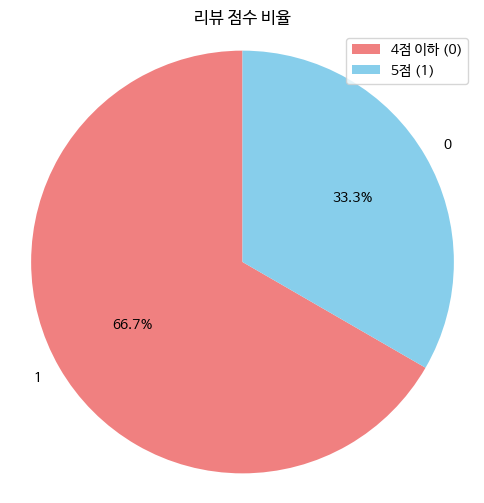

In [ ]:
import matplotlib.pyplot as plt

label_counts = review['라벨'].value_counts()

legend_labels = ['4점 이하 (0)', '5점 (1)']

# 파이차트 생성
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue'])
plt.title('리뷰 점수 비율')
plt.axis('equal')
plt.legend(legend_labels, loc="upper right")
plt.show()

## 텍스트 전처리

In [ ]:
# 불용어 정리
stop_words = [
    '것', '수', '들', '그', '이', '저', '및', '더', '등', '거', '제', '좀',
    '에서', '하다', '입니다', '으로', '하는', '에도', '하게', '하고', '하고싶다',
    '너무', '매우', '정말', '진짜', '때문', '위해', '하지만', '거나', '보다', '해서',
    '에서는', '으로서', '으로써', '하면서', '이면', '였다', '였다가', '이나', '에는', '곳', '분', '때', '탈', '서기', '년', '개', '시', '비', '하나', '날',
    '그냥', '정도', '안', '느낌', '거의', '이상', '타고', '한번', '말', '보고', '만', '듯', '별로', '도', '뭐', '원', '션', '함', '스', '밸리', '전', '다시', '어',
    '일', '프레', '가지', '왜', '해', '못', '애', '기분', '볼', '번', '이제', '역시', '가면', '만원', '임', '문', '자유', '장소', '지금', '한국',
    '할인', '내', '몇개', '조금', '월','꼭', '바로', '제대로', '기도', '레', '찬스', '게', '가세', '후', '앞', '요', '점', '다음', '또', '이후',
    '온', '뭔가', '곳도', '점점', '중', '동안', '대한', '계속', '자주', '또한', '음', '이번', '티', '완전','모든', '요즘', '전체', '나라', '년전',
    '베이', '항상', '땐', '외', '무슨', '인지', '안해', '초', '쪽', '토피아', '가기', '우리', '제로', '늘', '데리',
    '이다', '오다', '없다', '과', '같다', '놀다', '다', '자다', '한', '와', '고', '까지', '있다', '없다', '오다', '한', '이다', '다', '같다',
    '고', '과', '아니다', '서', '그리고', '이라', '나', '인데', '에', '가', '을', '는', '은', '가다', '의', '를', '로', '되다', '않다', '대', '타다',
    '적', '그래도', '되어다', '넘다', '많이', '생각', '기본', '먹다', '기', '그렇다', '들어가다', '서다', '그래도' ,
    '부터', '예전', '받다', '싶다', '인', '만에',
    '안되다', '두', '비다', '다녀오다', '엔', '같다', '하', '내다', '니', '나오다', '들다', '많다', '적다', '좋아요', '놀이기구', '많아서', '많고', '많음',
    '있어서', '있는', '있습니다', '있어요', '좋았습니다', '좋습니다', '같아요', '많아요', '좋은', '즐거운', '가서', '있어', '많으니', '생각보다', '재밌고', '좋네요',
    '갑니다', '왔어요', '재미있게', '추천합니다', '좋겠어요', '이미', '때문에', '차라리', '않고', '가세요', '아니면', '것도', '있고', '그런지', '이미', '같아요', '타려면',
    '엄청', '오랜만에', '그런데', '생각보다', '곳이', '비해', '가서', '근데', '것이', '절대', '갔는데', '있음', '곳이', '이젠', '생각이', '했는데', '이렇게', '최고', '행복',
    '완벽', '추천', '방문', '감사','준비','에버랜드', '성공', '힐링', '우리나라', '즐거움', '내외', '필수',
    '아들', '고민', '휴가', '만족', '사랑', '전반', '이유', '추가', '일반', '장사', '최악', '실망', '불편', '기쁨', '하루', '한창', '이해','유명', '세계', '사람', '시간', '아쉬움',
    '에', '에도', '인데도', '은',
    '놀이', '기구', '오랜만', '월드', '가능'
]

In [ ]:
import re
import pandas as pd
from kiwipiepy import Kiwi
from collections import Counter

# 0) 데이터프레임/컬럼 설정
text_col = '내용'

# 1) 형태소 분석기 (Java 불필요)
kiwi = Kiwi()

# 3) 전처리 함수: 한글/공백만 유지 → 품사분석 → 명사(NN*)만 추출 → 불용어/한글자 제거
def clean_and_tokenize_nouns(text: str):
    text = re.sub(r'[^가-힣\s]', ' ', str(text))
    # Kiwi 토큰: (form, tag, start, length, score)
    # 명사 품사: NNG(일반명사), NNP(고유명사), NNB(의존명사) 등 'NN'으로 시작
    tokens = [t.form for t in kiwi.tokenize(text) if t.tag.startswith('NN')]
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    return tokens

# 4) 토큰/클린문장 생성
review['tokens'] = review[text_col].apply(clean_and_tokenize_nouns)
review['clean_review'] = review['tokens'].apply(lambda toks: ' '.join(toks))

# 5) (선택) 상위 빈도 체크 — 너가 쓰던 패턴과 동일
all_tokens = [tok for toks in review['tokens'] for tok in toks]
word_counts = Counter(all_tokens)
most_common_words = word_counts.most_common(50)
print(most_common_words[:10])  # 상위 10개만 예시 출력

[('아이', 968), ('대기', 605), ('사파리', 559), ('퍼레이드', 510), ('평일', 482), ('동물', 449), ('이용', 437), ('익스프레스', 426), ('입장', 357), ('예약', 346)]


## 머신러닝 기반
- 머신러닝(TF-IDF + Logistic Regression) 을 이용해 키워드(단어)별 감정 영향력 분석

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=10000,  # 상위 5천 단어 사용
    ngram_range=(1, 2),) # “너무 비싸”, “줄 길다” 등 문맥 반영
X = vectorizer.fit_transform(review['clean_review'])
y = review['라벨']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

### Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 클래스 불균형 자동 보정 (class_weight='balanced')
logistic = LogisticRegression(
    max_iter=10000,
    n_jobs=-1,
    class_weight='balanced'
)

logistic.fit(X_train, y_train)

y_pred = logistic.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.49      0.48       656
           1       0.74      0.71      0.73      1312

    accuracy                           0.64      1968
   macro avg       0.60      0.60      0.60      1968
weighted avg       0.65      0.64      0.64      1968



### SVM 모델

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

svm = LinearSVC(
    C=0.5,                 # 규제 강도 (↑ 과적합, ↓ 과소적합 완화)
    loss='squared_hinge',
    max_iter=15000
)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.26      0.35       656
           1       0.70      0.87      0.78      1312

    accuracy                           0.67      1968
   macro avg       0.60      0.57      0.56      1968
weighted avg       0.63      0.67      0.63      1968

[[ 173  483]
 [ 173 1139]]


### XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1️⃣ 불균형 보정용 기본 파라미터 정의
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': 1.3   # 클래스 불균형 보정 (부정 클래스 가중치 ↑)
}

# 2️⃣ XGBClassifier 초기화
xgb = XGBClassifier(
    **params,                  # ← 여기서 params 딕셔너리 언패킹
    use_label_encoder=False,
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# 3️⃣ 모델 학습
xgb.fit(X_train, y_train)

# 4️⃣ 예측 및 평가
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:24:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.50      0.22      0.31       656
           1       0.70      0.89      0.78      1312

    accuracy                           0.67      1968
   macro avg       0.60      0.56      0.54      1968
weighted avg       0.63      0.67      0.62      1968

[[ 147  509]
 [ 147 1165]]


### 머신러닝 기반 결과

In [ ]:
import numpy as np

feature_names = np.array(vectorizer.get_feature_names_out())
coef = logistic.coef_.flatten() # svm, logistic
# coef = xgb.feature_importances_

pos_keywords = feature_names[np.argsort(coef)[-30:][::-1]]  # 상위 30개 긍정 단어
neg_keywords = feature_names[np.argsort(coef)[:30]]          # 상위 30개 부정 단어

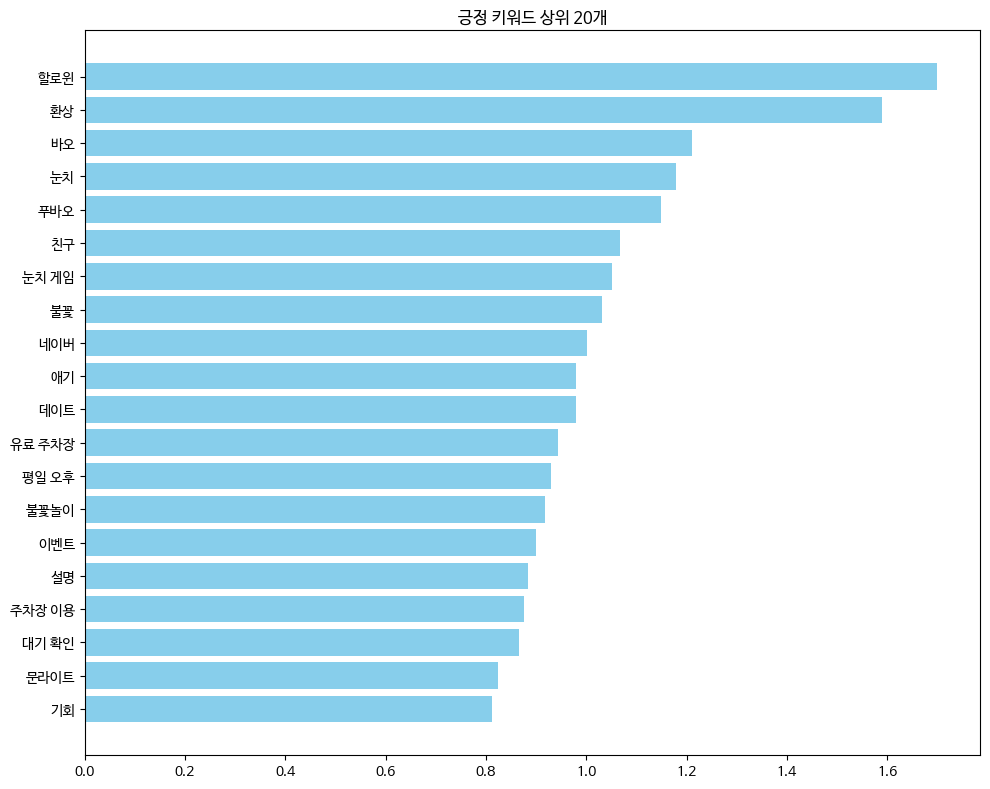

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

pos_keywords_20 = feature_names[np.argsort(coef)[-20:][::-1]]

plt.figure(figsize=(10, 8))
plt.barh(pos_keywords_20[::-1], np.sort(coef)[-20:], color='skyblue')
plt.title("긍정 키워드 상위 20개")
plt.tight_layout()
plt.show()

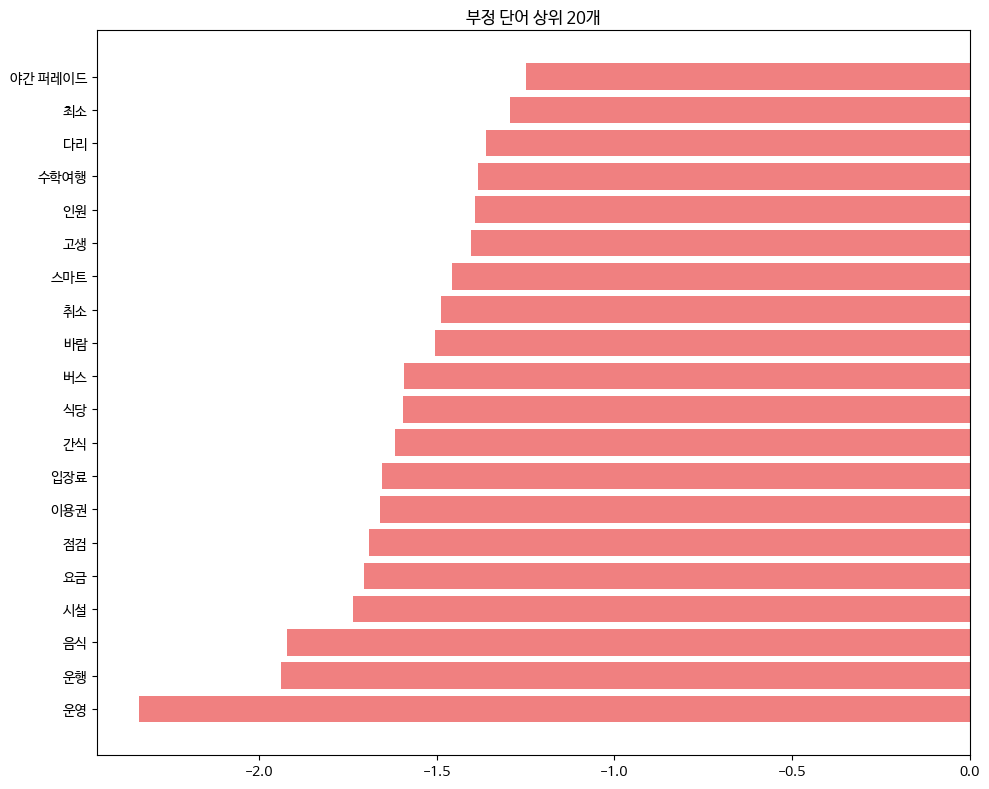

In [ ]:
neg_keywords_20 = feature_names[np.argsort(coef)[:20]]
plt.figure(figsize=(10, 8)) # Increase the figure size
plt.barh(neg_keywords_20, np.sort(coef)[:20], color='lightcoral')
plt.title("부정 단어 상위 20개")
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

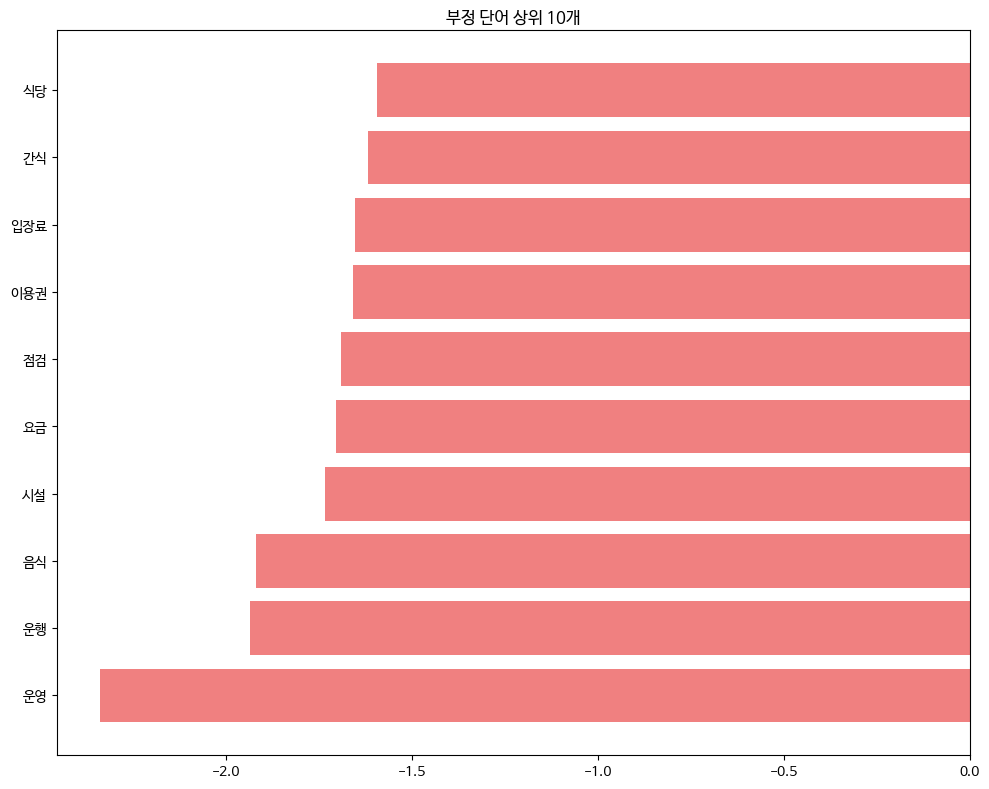

In [ ]:
neg_keywords_10 = feature_names[np.argsort(coef)[:10]]
plt.figure(figsize=(10, 8)) # Increase the figure size
plt.barh(neg_keywords_10, np.sort(coef)[:10], color='lightcoral')
plt.title("부정 단어 상위 10개")
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

## 단어 빈도수 기반

In [ ]:
positive_reviews = review[review['라벨'] == 1]
negative_reviews = review[review['라벨'] == 0]

In [ ]:
from collections import Counter

pos_word_counts = Counter()
for tokens in positive_reviews['tokens']:
    pos_word_counts.update(tokens)

neg_word_counts = Counter()
for tokens in negative_reviews['tokens']:
    neg_word_counts.update(tokens)

In [ ]:
top_pos_words = pos_word_counts.most_common(30)
top_neg_words = neg_word_counts.most_common(30)

print("Top 30 Positive Words:")
for word, count in top_pos_words:
    print(f"{word}: {count}")

print("\nTop 30 Negative Words:")
for word, count in top_neg_words:
    print(f"{word}: {count}")

Top 30 Positive Words:
아이: 667
사파리: 344
퍼레이드: 340
대기: 337
동물: 303
평일: 275
익스프레스: 274
이용: 236
가족: 226
날씨: 221
불꽃놀이: 211
입장: 210
축제: 194
예약: 191
스마트: 176
오후: 161
환상: 158
추억: 148
놀이공원: 148
주차장: 148
할로윈: 147
구경: 144
시설: 140
주말: 140
사진: 138
다양: 135
볼거리: 135
공연: 134
거리: 131
야간: 129

Top 30 Negative Words:
아이: 301
대기: 268
사파리: 215
평일: 207
이용: 201
시설: 183
퍼레이드: 170
스마트: 156
예약: 155
익스프레스: 152
주차장: 151
입장: 147
동물: 146
놀이공원: 123
음식: 120
주말: 119
직원: 102
코로나: 97
주차: 95
구경: 94
날씨: 92
운영: 91
오후: 89
거리: 89
가격: 82
식당: 81
축제: 80
불꽃놀이: 80
가족: 78
볼거리: 73


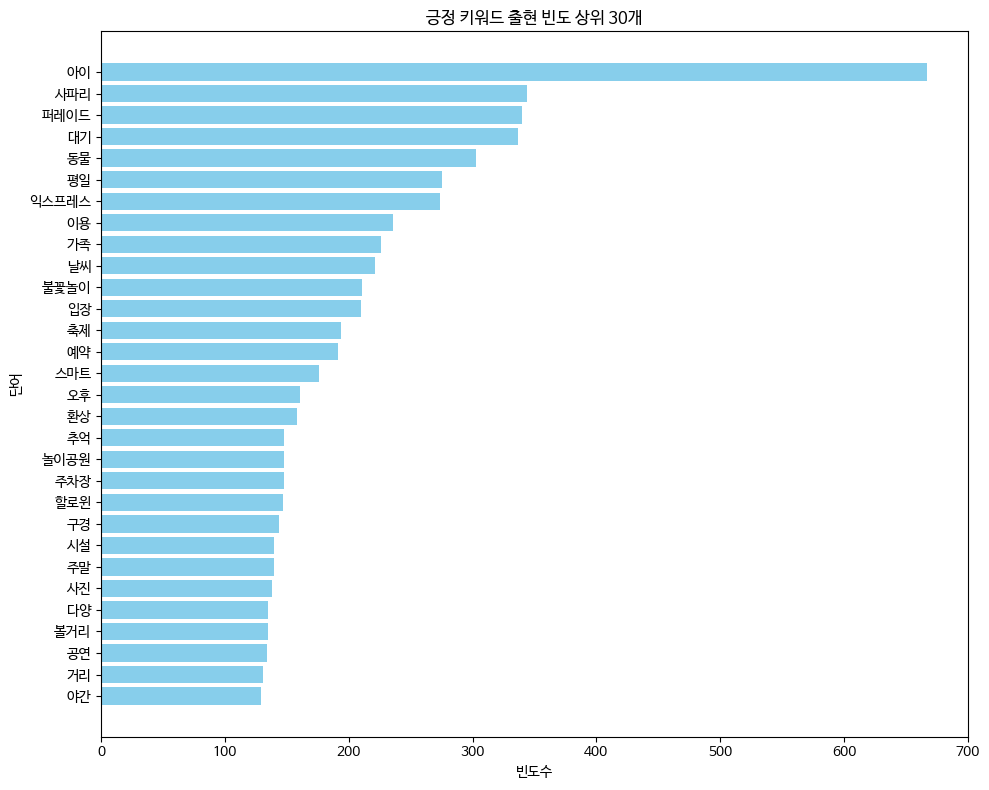

In [ ]:
import matplotlib.pyplot as plt


pos_words, pos_counts = zip(*top_pos_words)
neg_words, neg_counts = zip(*top_neg_words)

# 긍정 단어 바차트 생성
plt.figure(figsize=(10, 8))
plt.barh(pos_words[::-1], pos_counts[::-1], color='skyblue')
plt.title("긍정 키워드 출현 빈도 상위 30개")
plt.xlabel("빈도수")
plt.ylabel("단어")
plt.tight_layout()
plt.show()



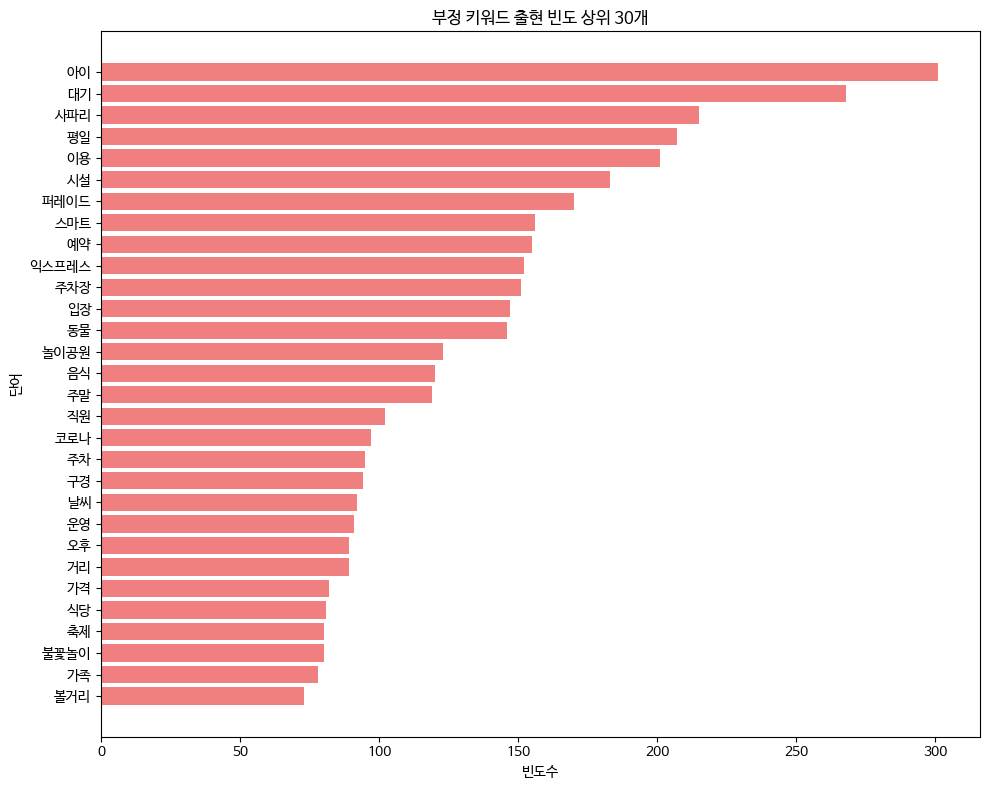

In [ ]:
# 부정 단어 바차트 생성
plt.figure(figsize=(10, 8))
plt.barh(neg_words[::-1], neg_counts[::-1], color='lightcoral')
plt.title("부정 키워드 출현 빈도 상위 30개")
plt.xlabel("빈도수")
plt.ylabel("단어")
plt.tight_layout()
plt.show()

In [ ]:

# 리스트를 튜플로 변경
pos_word_dict = dict(top_pos_words)
neg_word_dict = dict(top_neg_words)

# 긍정 워드 클라우드 세팅
wc_pos = WordCloud(
    font_path=font_path,
    background_color='white',
    width=800,
    height=600,
)

# 부정 워드 클라우드 세팅
wc_neg = WordCloud(
    font_path=font_path,
    background_color='white',
    width=800,
    height=600,
)


In [ ]:
import random
 # 워드 클라우드 색상 함수 정의
def deep_green_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(%d, 80%%, %d%%)" % (random.randint(100, 150), random.randint(30, 70))

def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(%d, 80%%, %d%%)" % (random.randint(0, 30), random.randint(30, 70))

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128153 (\N{BLUE HEART}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


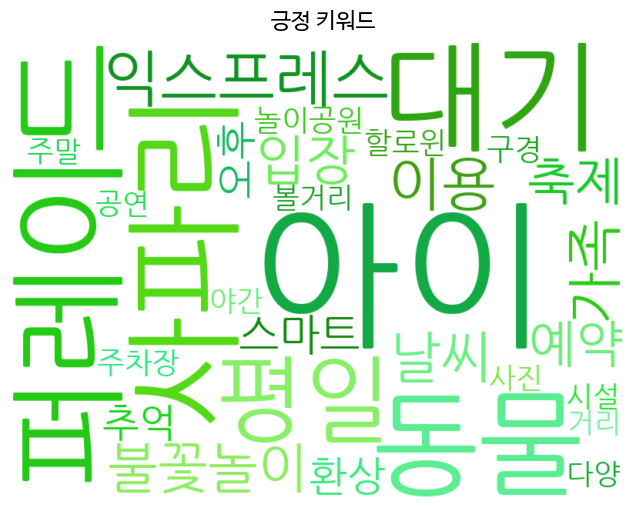

In [ ]:
# 긍정 워드 클라우드 생성
plt.figure(figsize=(10,6))
plt.title("💙 긍정 키워드", fontsize=16)
plt.imshow(wc_pos.generate_from_frequencies(pos_word_dict).recolor(color_func=deep_green_color_func), interpolation='bilinear')
plt.axis('off')
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128156 (\N{PURPLE HEART}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


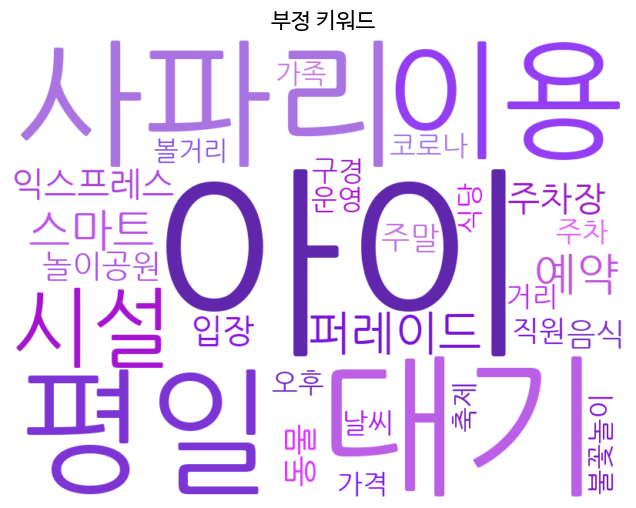

In [ ]:
import random
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# 💜 보라색 계열 색상 함수 정의
def purple_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl({}, {}%, {}%)".format(random.randint(260, 290), random.randint(60, 100), random.randint(40, 70))

# 보라색 워드클라우드 출력
plt.figure(figsize=(10,6))
plt.title("💜 부정 키워드", fontsize=16)
plt.imshow(
    wc_neg.generate_from_frequencies(neg_word_dict)
          .recolor(color_func=purple_color_func),
    interpolation='bilinear'
)
plt.axis('off')
plt.show()

## 긍정 리뷰에 대한 각 요인의 영향 (머신러닝 포함)

In [ ]:
# =========================
# 0) 기본 세팅 (Colab)
# =========================
from scipy.stats import chi2_contingency
import statsmodels.api as sm


# =========================
# 1) 데이터 불러오기
# =========================
# 인코딩 자동 선택
encodings = ["utf-8-sig", "utf-8", "cp949"]
for enc in encodings:
    try:
        df = pd.read_csv(csv_name, encoding=enc)
        break
    except Exception:
        pass

# 컬럼명 표준화
review = review.rename(columns={"내용": "text", "라벨": "label"})
review["text"] = review["text"].fillna("").astype(str)
review["label"] = review["label"].astype(int)   # 1=긍정, 0=부정 가정

print(review.head(), review.shape)

# =========================
# 2) 가설별 키워드 사전
# =========================
kw_oper = [  # 운영/대기/혼잡
    "대기","줄","웨이팅","혼잡","예약","사전예약","우선권","시간지정","분산",
    "동선","운영","직원","배치","느리","지연","줄서","대기시간","긴줄","포화","밀집"
]
kw_content = [  # 콘텐츠/IP/행사
    "콘텐츠","컨텐츠","볼거리","공연","IP","아이피","한류","케이팝","K팝","K-pop",
    "드라마","판다","산리오","이벤트","체험","테마","캐릭터","쇼","즐길거리","볼거","티니핑","푸바오","러바오","아이바오",
]
kw_facility = [  # 시설/노후/청결
    "노후","낡","오래됨","시설","리모델링","보수","수리","관리","청결","위생",
    "부서","고장","깨끗","더럽","페인트","깨짐","녹","냄새","파손","누수","망가"
]

# 부분일치 정규식 탐색 함수
def has_any(text, keywords):
    return int(any(re.search(k, text) for k in keywords))

review["oper_flag"] = review["text"].apply(lambda x: has_any(x, kw_oper))
review["content_flag"] = review["text"].apply(lambda x: has_any(x, kw_content))
review["facility_flag"] = review["text"].apply(lambda x: has_any(x, kw_facility))

print(review[["text","label","oper_flag","content_flag","facility_flag"]].head())

# =========================
# 3) 교차표 & 카이제곱검정
# =========================
def chi_summary(flag_col):
    tab = pd.crosstab(review[flag_col], review["label"], dropna=False)
    for c in [0,1]:
        if c not in tab.columns: tab[c] = 0
    tab = tab[[0,1]]  # 열 순서 고정 (0=부정, 1=긍정)
    chi2, p, dof, exp = chi2_contingency(tab.values)
    return tab, chi2, p, dof

chi_results = []
for col in ["oper_flag","content_flag","facility_flag"]:
    tab, chi2, p, dof = chi_summary(col)
    print(f"\n=== {col} ===")
    print(tab)
    print(f"chi2={chi2:.3f}, p={p:.5f}, dof={dof}")
    chi_results.append([col, chi2, p, dof])

chi_df = pd.DataFrame(chi_results, columns=["flag","chi2","p_value","dof"])
display(chi_df)

# =========================
# 4) 로지스틱 회귀 (label ~ flags)
# =========================
X = review[["oper_flag","content_flag","facility_flag"]]
X = sm.add_constant(X)         # 절편
y = review["label"]

logit = sm.Logit(y, X, missing='drop').fit(disp=False)
print(logit.summary())

# 오즈비(= exp(coef)) 및 95% CI
params = logit.params
conf = logit.conf_int()
odds = np.exp(params)
odds_ci = np.exp(conf)

summary_table = pd.DataFrame({
    "coef": params.round(3),
    "odds_ratio": odds.round(3),
    "ci_low": odds_ci[0].round(3),
    "ci_high": odds_ci[1].round(3),
    "p_value": logit.pvalues.round(5)
})
display(summary_table)

# 해석 도움말
print(
    "\n[해석]\n"
    "- 오즈비 < 1 : 해당 요인 언급 시 '긍정(=1)' 확률이 낮아지는 경향(부정 방향)\n"
    "- 오즈비 > 1 : 해당 요인 언급 시 '긍정(=1)' 확률이 높아지는 경향(긍정 방향)\n"
    "- p_value < 0.05 : 통계적으로 유의함"
)

# =========================
# 5) 결과 저장 & 다운로드
# =========================
chi_df.to_csv("chi_square_summary.csv", index=False, encoding="utf-8-sig")
summary_table.to_csv("logistic_regression_summary.csv", encoding="utf-8-sig")

print("\n생성된 파일:")
print("- chi_square_summary.csv")
print("- logistic_regression_summary.csv")



                                                text  label  \
0  겸사겸사 에버랜드 다시 방문요😇😇 🍄🥬🍄🥬🍄🥬🍄🥬🍄🥬🍄🥬🍄🥬🍄 어머낫~아들이 좋아하...      1   
1  키이스케이프와 콜라보한 방탈출이 있다고 해서 다녀왔는데 너무너무너무 재미있었습니다....      1   
2  에버랜드 1박2일 가족 나들이~ 화창한 날씨가 아닌 흐리고 비도 오고 아쉬움이 많긴...      1   
3  에버랜드에 오랜만에 갔어요^^ 오랜만에가니 새로워요 먹거리도 많고 볼거리 놀거리 진...      1   
4  일요일 오후 5시에 방문하니 주차도 수월하고 놀이기구 대기 시간도 짧아 여유롭게 즐...      1   

                                              tokens  \
0  [어머낫, 케이팝, 열광, 한참, 인기, 케이팝, 입장, 아드님, 선물, 에버, 의...   
1                [이스케이프, 콜라, 탈출, 공간, 활용, 체험, 탈출, 콜라]   
2  [가족, 나들이, 날씨, 비도, 예약, 사파리, 투어, 동물, 친구, 야간, 퍼레이...   
3  [먹거리, 볼거리, 거리, 팬더, 동물, 아이, 시설, 관리, 테마, 추억, 동산,...   
4  [일요일, 오후, 주차, 대기, 여유, 가을, 바람, 포 시즌스, 가든, 산책, 사...   

                                        clean_review  
0       어머낫 케이팝 열광 한참 인기 케이팝 입장 아드님 선물 에버 의자 아드님 마무리  
1                         이스케이프 콜라 탈출 공간 활용 체험 탈출 콜라  
2  가족 나들이 날씨 비도 예약 사파리 투어 동물 친구 야간 퍼레이드 우중 큐패스 예약...  
3              먹거리 볼거리 거리 팬더 동물 아이 시설 관리 테마 추억 동산 평일  
4  일요일 오후

,flag,chi2,p_value,dof
0,oper_flag,153.297739,3.297637e-35,1
1,content_flag,1.955169,1.620309e-01,1
2,facility_flag,99.873597,1.624404e-23,1


                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                 6560
Model:                          Logit   Df Residuals:                     6556
Method:                           MLE   Df Model:                            3
Date:                Thu, 13 Nov 2025   Pseudo R-squ.:                 0.02789
Time:                        02:24:33   Log-Likelihood:                -4059.3
converged:                       True   LL-Null:                       -4175.8
Covariance Type:            nonrobust   LLR p-value:                 3.263e-50
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.9118      0.034     27.198      0.000       0.846       0.978
oper_flag        -0.7036      0.060    -11.691      0.000      -0.822      -0.586
content_flag      0.1909      0.074     

,coef,odds_ratio,ci_low,ci_high,p_value
const,0.912,2.489,2.331,2.658,0.00000
oper_flag,-0.704,0.495,0.440,0.557,0.00000
content_flag,0.191,1.210,1.046,1.400,0.01021
facility_flag,-0.882,0.414,0.341,0.503,0.00000



[해석]
- 오즈비 < 1 : 해당 요인 언급 시 '긍정(=1)' 확률이 낮아지는 경향(부정 방향)
- 오즈비 > 1 : 해당 요인 언급 시 '긍정(=1)' 확률이 높아지는 경향(긍정 방향)
- p_value < 0.05 : 통계적으로 유의함

생성된 파일:
- chi_square_summary.csv
- logistic_regression_summary.csv


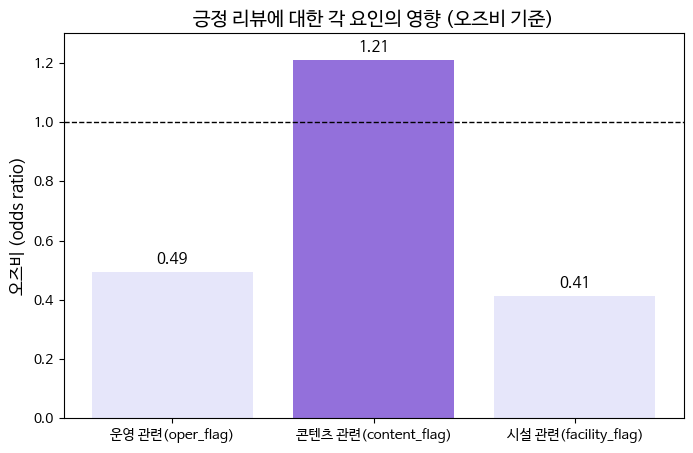

In [ ]:
# 데이터프레임 생성
df_plot = pd.DataFrame({
    "변수": ["운영 관련(oper_flag)", "콘텐츠 관련(content_flag)", "시설 관련(facility_flag)"],
    "오즈비": [0.4950, 1.210, 0.414],
    "p_value": [0.000, 0.010, 0.000]
})

# 색상: p<0.05면 빨간색(유의), 아니면 회색
colors = ["#E6E6FA" if 오즈비 < 1 else "#9370DB" for 오즈비 in df_plot["오즈비"]]

plt.figure(figsize=(8,5))
bars = plt.bar(df_plot["변수"], df_plot["오즈비"], color=colors)
plt.axhline(1, color="black", linestyle="--", linewidth=1)
plt.title("긍정 리뷰에 대한 각 요인의 영향 (오즈비 기준)", fontsize=14)
plt.ylabel("오즈비 (odds ratio)", fontsize=12)

# 값 표시
for bar, val in zip(bars, df_plot["오즈비"]):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.03, f"{val:.2f}", ha='center', fontsize=11)

plt.ylim(0, 1.3)
plt.show()


---
# 1️⃣ [리뷰데이터 기반 가설 1·2 검증]

In [ ]:
# 월본 데이터 다시 불러오기
review = pd.read_csv('/content/naver+google_review_final.csv')

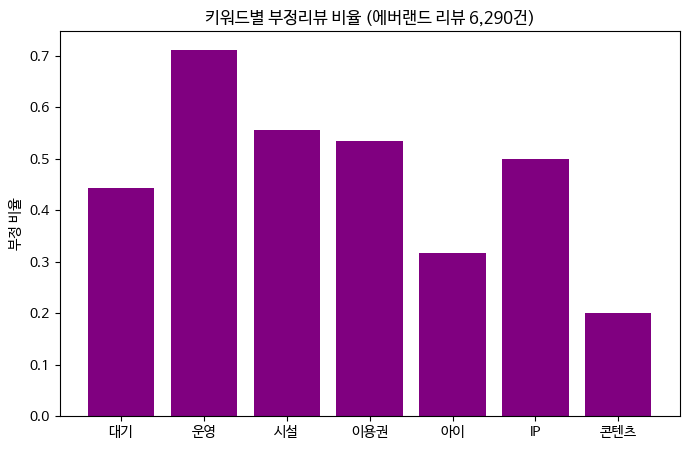

In [ ]:
keywords = ['대기', '운영', '시설', '이용권', '아이', 'IP', '콘텐츠']
results = []

for k in keywords:
    subset = review[review['내용'].str.contains(k, case=False, na=False)]
    pos = subset[subset['라벨']==1].shape[0]
    neg = subset[subset['라벨']==0].shape[0]
    total = pos + neg
    results.append({'키워드':k, '긍정비율':pos/total if total else 0, '부정비율':neg/total if total else 0})

res_df = pd.DataFrame(results)

plt.figure(figsize=(8,5))
plt.bar(res_df['키워드'], res_df['부정비율'], color='purple')
plt.title('키워드별 부정리뷰 비율 (에버랜드 리뷰 6,290건)')
plt.ylabel('부정 비율')
plt.show()


-----
# 2️⃣ [디즈니 대기시간 비교로 가설 1·3 보조 검증]

         date  hour  avg_wait
0  2018-01-01    21         0
1  2018-01-01    19         5
2  2018-01-01    22         0
3  2018-01-01    12         5
4  2018-01-01    17         5
[21 19 22 12 17 18 13 15 11 20]


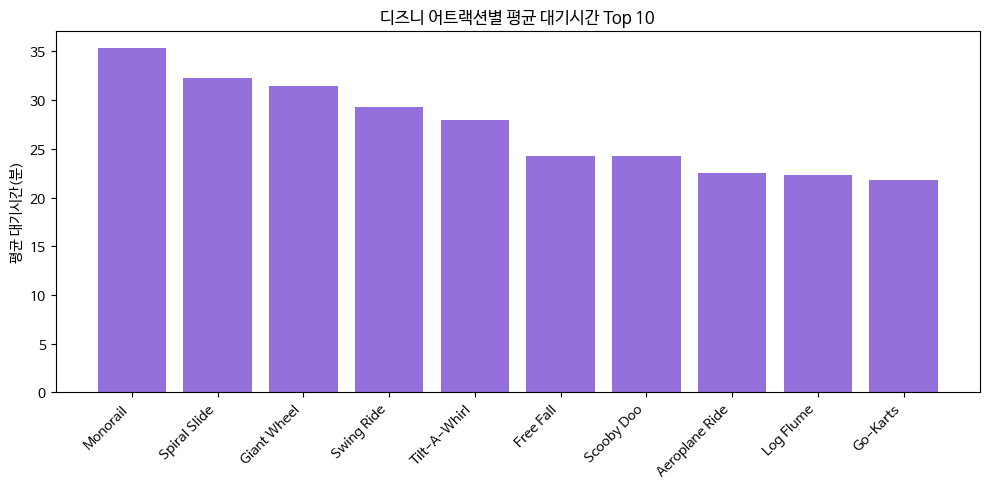

In [ ]:
#컬럼명 한글로 통일

df1 = df1.rename(columns={
    'WORK_DATE': 'date',
    'DEB_TIME_HOUR': 'hour',
    'ENTITY_DESCRIPTION_SHORT': 'ride',
    'WAIT_TIME_MAX': 'avg_wait'
})

# 데이터 타입 확인
print(df1[['date', 'hour', 'avg_wait']].head())
print(df1['hour'].unique()[:10])

# date를 datetime으로 변환
df1['date'] = pd.to_datetime(df1['date'], errors='coerce')

# 어트랙션별 평균 대기시간 상위 10개
top10 = df1.groupby('ride')['avg_wait'].mean().nlargest(10)

plt.figure(figsize=(10,5))
plt.bar(top10.index, top10.values, color='mediumpurple')
plt.xticks(rotation=45, ha='right')
plt.ylabel('평균 대기시간(분)')
plt.title('디즈니 어트랙션별 평균 대기시간 Top 10')
plt.tight_layout()
plt.show()

# 날짜별 평균 대기시간
daily = df1.groupby('date')['avg_wait'].mean()

plt.figure(figsize=(8,4))
plt.plot(daily.index, daily.values, color='orchid')
plt.title('일자별 평균 대기시간 추이')
plt.xlabel('날짜')
plt.ylabel('평균 대기시간(분)')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()